# Simple Engine

This is a very simple engine example, that requires no additional modules other than those installed with Bamboo.

- Chamber temperature: 2615.09 K
- Chamber pressure: 15 bar 

In [3]:
# Import required modules
import cusfbamboo as bam
import numpy as np
from CoolProp.CoolProp import PropsSI
import cantera as ct

### Engine Operating Point

Pressures, temperatures, mass flow rates, geometry.

In [6]:
# Chamber conditions
pc = 15e5                   # Chamber pressure (Pa)
Tc = 2615.09                   # Combustion chamber temperature (K) - would normally get this from an equilibrium program (e.g. Cantera, NASA CEA, ProPEP).
pe = 1.01325e5
Isp = 1981.3
Thrust = 10000
mdot = Thrust/Isp
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
perfect_gas = bam.PerfectGas(gamma = 1.2413, cp = 1907.2)


# Geometry properties
Rc = 0.1                  # Chamber radius (m)
At = bam.isen.get_throat_area(perfect_gas,chamber_conditions,mdot)
Ae = bam.isen.get_exit_area(perfect_gas, chamber_conditions,pe, mdot)
Rt =(At/np.pi)**0.5                # Throat radius (m)
Re =(Ae/np.pi)**0.5
area_ratio = Ae/At              # Area ratio (A_exit / A_throat)
Lc = 0.3                   # Length of chamber (up to beginning of nozzle converging section) (m)
theta_conv = 45             # Angle of converging section (deg)

# Use the in-built Rao geometry generator
xs, rs = bam.rao.get_rao_contour(r_c = Rc, 
                                 r_t = Rt, 
                                 area_ratio = area_ratio, 
                                 L_c = Lc, 
                                 theta_conv = theta_conv)

C:\Users\USER\AppData\Local\Temp/ipykernel_13048/282460036.py:23: UserWarning: The area ratio provided (2.809741674968918) is outside of the range of available data. Maximum available is 54.623, minimum is 3.678. Will use a 15 degree cone instead.
  xs, rs = bam.rao.get_rao_contour(r_c = Rc,


### Transport Properties



In [8]:
OF_ratio = 3.5                             # Oxidiser/fuel mass ratio
ipa_mass = 1
n2o_mass = OF_ratio

# Setup the exhaust gas transport properties using Cantera
gri30 = ct.Solution('gri30.yaml')

ipa_ct = ct.Quantity(gri30, constant = "TP", mass = ipa_mass)
ipa_ct.TPX = Tc, pc, "C:3, H:8, O:1"

n2o_ct = ct.Quantity(gri30, constant = "TP", mass = n2o_mass)
n2o_ct.TPX = Tc, pc, "N:2, O:1"

# Mix and reach equilibrium at chamber conditions
quantity = ipa_ct + n2o_ct
quantity.equilibrate("TP")

gas = ct.Solution('gri30.yaml')
gas.TPY = quantity.TPY
gas()

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number


# Coolant is pure water - use CoolProp
def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "Ethanol")
    except ValueError:
        return PropsSI("PRANDTL", "Q", 0, "P", p, "Ethanol")

def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "Ethanol")
    except ValueError:
        return PropsSI("VISCOSITY", "Q", 0, "P", p, "Ethanol")

def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "Ethanol")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "Q", 0, "P", p, "Ethanol")

def rho_coolant(T, p):
    try:
        return PropsSI("DMASS", "T", T, "P", p, "Ethanol")
    except ValueError:
        return PropsSI("DMASS", "Q", 0, "P", p, "Ethanol")

def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "Ethanol")
    except ValueError:
        return PropsSI("CPMASS", "Q", 0, "P", p, "Ethanol")


# Transport property objects
exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)


  gri30:

       temperature   2615.1 K
          pressure   1.5e+06 Pa
           density   1.5795 kg/m^3
  mean mol. weight   22.896 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy           -816.75            -18700  J
   internal energy       -9.5047e+05       -2.1762e+07  J
           entropy             10888         2.493e+05  J/K
    Gibbs function       -2.8475e+07       -6.5196e+08  J
 heat capacity c_p            1801.6             41250  J/K
 heat capacity c_v            1438.5             32935  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2          0.012765           0.14497           -19.603
                 H        0.00017792         0.0040412           -9.8013
                 O          1.57e-05        2.2469e-05           -19.193


### Engine Set Up
We will now use Bamboo to do the cooling system analysis. Will set up:

- Perfect gas model
- Combustion chamber conditions
- Geometry
- Walls
- Exhaust gas transport properties

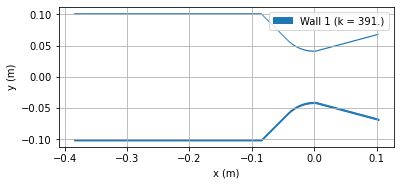

Sea Level Thrust = 10198.045921566494 N
Sea Level Specific Impulse = 2020.5388384399694 m/s


In [9]:
# Set up the objects we need
geometry = bam.Geometry(xs = xs, rs = rs)
exhaust_transport = bam.materials.CO2                                  # Use the built-in CO2 approximation
wall = bam.Wall(material = bam.materials.CopperC106, thickness = 2e-3) # Use the built in C106 copper data

# Submit them all at inputs to the Engine object
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    walls = wall)
engine.plot()
bam.show()

print(f"Sea Level Thrust = {engine.thrust(p_amb = 1e5)} N")
print(f"Sea Level Specific Impulse = {engine.isp(p_amb = 1e5)} m/s")

### Cooling Jacket

Add the cooling channel details. We will use 'vertical' channels (`configuration = 'vertical'` as opposed to `configuration = 'spiral'`). This image is an example of 'vertical' channels: https://slideplayer.com/slide/4179683/14/images/6/Cooling+Channels.jpg

In [12]:
# Cooling jacket properties
inlet_T = 298.15                           # Coolant inlet static temperature (K)
inlet_p = 30e5                             # Coolant inlet static pressure (bar)
mdot_coolant = mdot*1/(OF_ratio + 1) # Coolant mass flow rate (kg/s)

# Add a cooling jacket to the engine
engine.cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
                                         p_coolant_in = inlet_p, 
                                         mdot_coolant = mdot_coolant, 
                                         channel_height = 2e-3,
                                         blockage_ratio = 0.5,
                                         number_of_channels = 100,
                                         coolant_transport = coolant_transport,   # Use bamboo's built-in water approximation
                                         configuration = 'vertical')



### Run Cooling Analysis

In [13]:
# Run the heating analysis - see the documentation for details on the various arguments.
cooling_data = engine.steady_heating_analysis()

TypeError: object of type 'numpy.float64' has no len()

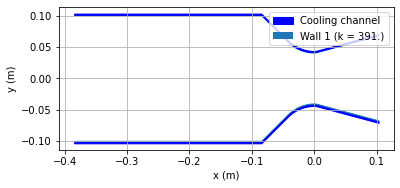

NameError: name 'cooling_data' is not defined

In [15]:
# Use the built in plotting functions to quickly generate some plots
engine.plot()
bam.show()

bam.plot.plot_coolant_velocity(cooling_data)
bam.show()

bam.plot.plot_temperatures(cooling_data, only_indexes = [0, 1, 2])   # Exclude the exhaust gas temperature from the plot
bam.show()

bam.plot.plot_p_coolant(cooling_data)
bam.show()

bam.plot.plot_q_per_area(cooling_data)
bam.show()

bam.plot.plot_tangential_stress(cooling_data, wall_index = 0)
bam.show()